# Ec 143 - Problem Set 4
# Production Function Estimation
Due by 5PM on May 2nd. The GSI, Mengsi Gao (mengsi.gao@berkeley.edu) will handle the logistics of problem set collection.    

Working with peers on the problem set is actively encouraged, but everyone needs to turn in their own Jupyter Notebook and any other accompanying materials. 

This problem set reviews the material on production function estimation developed in lecture. Any "pencil and paper" and/or narrative answers may be placed in markdown boxes in this Jupyter notebook (preferred). Alternatively you can hand write your answers and turn in a pdf scan of them.

Any computational questions should be answered by writing the required code and executing it. This should be included in this notebook.

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The datafile needed to complete this problem set is available on the course GitHub repository. This file is called *semiconductor_firms.out*. This file includes 5 years of data (2010 to 2014 inclusive) on 110 semi-conductor firms (NAICS 4-digit code 3344). This extract was constructed from the [*Compustat*](https://www.marketplace.spglobal.com/en/datasets/compustat-fundamentals-(8)?utm_source=google&utm_medium=cpc&utm_campaign=DMS_Marketplace_Search_Google&utm_term=&utm_content=586436401424&_bt=586436401424&_bk=&_bm=&_bn=g&_bg=133704002389&gclid=Cj0KCQjwr-SSBhC9ARIsANhzu17vcn9JW4yOskcTp4OtipZFTnC7xjdbrjWjqOJFDtD9YMe9NeJUkfMaAg2pEALw_wcB) datbase. This database is available to Berkeley students through the Haas Business School Library. Included in the file are the variables:  

**Y** : total real sales by the firm (in millions of 2009 US$)

**K** : capital stock (in millions of 2009 US$)  

**L** : employees (in thousands)  

**M** : materials expenditures (in millions of 2009 US$)  

**VA** : total real valued added by the firm (in millions of 2009 US$)  

**w** : annual wage rate (in 2009 US$)  

**i** : real investment (in millions of 2009 US$)  

**r&d** : total research & development spending (in millions of 2009 US$).  

The name of the firm is given in the **conm** column; **gvkey** is a unique firm *Compustat* firm identifier.

In [2]:
data = '/Users/bgraham/Dropbox/Teaching/Berkeley_Courses/Ec143/Ec143_Spring2022/Datasets/'
graphics = '/Users/bgraham/Dropbox/Teaching/Berkeley_Courses/Ec143/Ec143_Spring2022/Graphics/'

## PART I: Back-of-the-Envelope Productivity Analysis
We will begin by loading the dataset and doing some basic "back of the envelope" productivity analysis of the type discussed in Syverson (2011, _Journal of Economic Literature_). A copy of this paper can be found [here](http://home.uchicago.edu/syverson/productivitysurvey.pdf). I encourage you to have at least a quick look at this paper to get an overview of economic questions in productivity analysis. 

We will work with a so-called "valued added" production function. Value added is, roughly, a measure of firm output that takes into account the raw materials/inputs used in production:   

$$ O_{t}=A_{t}K_{t}^{\alpha}L_{t}^{\beta} $$  

where $O_{t}$ is valued added and $A_{t}$ is a firm's total factor productivity in period $t$.   

In our dataset we observe $VA_{t} = P_{t} \times O_{t}$ (i.e., total sales minus the cost of materials used). Further assume, in this part of the problem set, constant returns-to-scale (CRS) such that $\alpha = 1 - \beta$.

### Question 1
Assume (unlike in the Olley-Pakes model discussed in lecture and also below), that firms are able to freely adjust their labor and capital input levels each period. Specifically that they choose capital and labor each period to maximize profits:

$$ \Pi_{t}=P_{t}O_{t}-W_{t}L_{t}-R_{t}K_{t}. $$

Show that this implies the equality:

$$ \beta=\frac{W_{t}L_{t}}{P_{t}O_{t}}. $$  

Use this result to justify the following, *time-specific*, estimate of $\beta$:

$$ \hat{\beta}_{t}=\frac{1}{N}\sum_{i=1}^{N}\frac{\frac{\text{W}_{it}(L_{it}\times1,000)}{1,000,000}}{\text{VA}_{it}}. $$  
Discuss this estimate; including any strengths and weaknesses you can think of. 

Next consider the following measure of productivity:

$$ \hat{TFPR}_{it}=\frac{\text{VA}_{it}}{K_{it}^{1-\hat{\beta}_{t}}\text{L}_{it}^{\hat{\beta}_{t}}} $$  

This is a revenue-based measure of productivity. How does it compare with the theoretical TFP measure, $A_{it}$? You might find [this](https://www.aeaweb.org/articles?id=10.1257/mac.20170282) article helpful. See also the Syverson (2011) survey.

Next we will load the dataset and organize it a bit. We will actually drop seven firms with at least one year where their measured value added is negative. This leaves us with 103 firms.

In [3]:
firms = pd.read_csv(data + 'semiconductor_firms.out', header = 0, sep='\t+', engine='python')
firms.set_index(['gvkey','year'], inplace=True)
firms.drop(['gvkey.1', 'year.1'], axis=1, inplace=True)
sample = firms.groupby('gvkey').filter(lambda g: ~ (g.VA <=0).any())
sample[0:5]

conm            Y            K       L  \
gvkey year                                                             
1161  2010  ADVANCED MICRO DEVICES  6569.283995  7780.788356  11.100   
      2011  ADVANCED MICRO DEVICES  6761.444940  2108.861479  11.093   
      2012  ADVANCED MICRO DEVICES  5576.869671  2279.734654  10.340   
      2013  ADVANCED MICRO DEVICES  5436.098402  2302.573526  10.671   
      2014  ADVANCED MICRO DEVICES  5622.785250  1834.114746   9.687   

                      M           VA             w           i          r&d  \
gvkey year                                                                    
1161  2010  3683.676331  2885.607664  58192.890525  146.079060  1386.764053   
      2011  3826.664337  2934.780603  60953.890816  241.732740  1404.950687   
      2012  3310.401201  2266.468469  62223.959351  126.189550  1284.666546   
      2013  3286.875560  2149.222842  62682.861774   78.837707  1127.191501   
      2014  3621.163044  2001.622205  64311.755155   87.691768   989.532372   

            naics_4digit  
gvkey year                
1161  2010          3344  
      2011          3344  
      2012          3344  
      2013          3344  
      2014          3344

In [4]:
sample['wage_bill'] = (sample['w']*sample['L']*1000)/1000000
sample['beta_it'] = sample['wage_bill']/sample['VA']
sample['beta_hat_t'] = sample['beta_it'].groupby(level=[1,1]).transform('mean')
sample['TFPR_it']=sample['VA']/((sample['K']**(1-sample['beta_hat_t']))*(sample['L']**(sample['beta_hat_t'])))
sample[['beta_it','beta_hat_t','TFPR_it']]

beta_it  beta_hat_t    TFPR_it
gvkey  year                                 
1161   2010  0.223849    0.484157   8.850722
       2011  0.230396    0.496995  18.887648
       2012  0.283876    0.529683  17.326303
       2013  0.311224    0.527957  15.933980
       2014  0.311242    0.525514  17.166270
...               ...         ...        ...
264416 2010  0.682002    0.484157  18.848740
       2011  0.680917    0.496995  18.385700
       2012  0.799289    0.529683  18.645065
       2013  0.764297    0.527957  21.048952
       2014  0.697928    0.525514  22.378052

[515 rows x 3 columns]

### Question 2
Add comments to the two blocks of code immediately above.

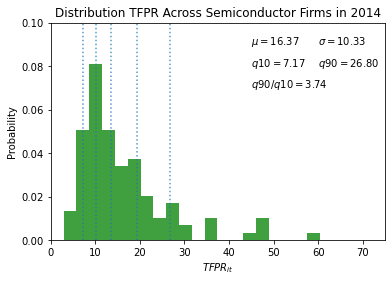

In [5]:
TFPR_2014 = sample.query('year == 2014')['TFPR_it']

fig, ax = plt.subplots(figsize = (6,4))
n, bins, patches = plt.hist(TFPR_2014, 20, density=True, facecolor='g', alpha=0.75)


plt.xlabel(r'$TFPR_{it}$')
plt.ylabel('Probability')
plt.title('Distribution TFPR Across Semiconductor Firms in 2014')

# Calculate percentiles
quantiles = [TFPR_2014.quantile(0.10), TFPR_2014.quantile(0.25), TFPR_2014.quantile(0.5), \
             TFPR_2014.quantile(0.75), TFPR_2014.quantile(0.90)]


# Plot the lines with a loop
for q in quantiles:
    ax.axvline(q, alpha = 0.75, ymax = 1, linestyle = ":")

plt.text(45, .09, r"$\mu = {0:.2f}$".format(np.mean(TFPR_2014)))
plt.text(60, .09, r"$\sigma = {0:.2f}$".format(np.std(TFPR_2014)))
plt.text(45, .08, r"$q10 = {0:.2f}$".format(quantiles[0]))
plt.text(60, .08, r"$q90 = {0:.2f}$".format(quantiles[4]))
plt.text(45, .07, r"$q90/q10 = {0:.2f}$".format(quantiles[4]/quantiles[0]))
plt.xlim(0, 75)
plt.ylim(0, 0.1)
plt.show()

### Question 3
Add comments to the the block of code immediately above. Furthermore comment on the plot. What does it suggest about the distribution of productivity across semi-conductor firms in 2014?

In [6]:
gvkeys = list(set(sample.index.get_level_values(0).tolist()))
sample.reset_index(level='year', inplace=True)

N = len(gvkeys)
B = 10

boostrap_results = np.zeros((B,3))

for b in range(0,B):
               
    boostrap_sampled_firms = list(np.random.choice(gvkeys, size=(N,), replace=True))
    
    bs_sample = sample.loc[boostrap_sampled_firms]
    bs_sample.reset_index(level='gvkey', inplace=True)
    bs_sample.set_index(['gvkey','year'], inplace=True)
    
    bs_sample['beta_hat_t'] = bs_sample['beta_it'].groupby(level=[1,1]).transform('mean')
    bs_sample['TFPR_it']=bs_sample['VA']/((bs_sample['K']**(1-bs_sample['beta_hat_t']))*(bs_sample['L']**(bs_sample['beta_hat_t'])))
    bs_TFPR_2014 = bs_sample.query('year == 2014')['TFPR_it']
    boostrap_results[b,:] = [bs_TFPR_2014.quantile(0.10), bs_TFPR_2014.quantile(0.90), bs_TFPR_2014.quantile(0.90)/bs_TFPR_2014.quantile(0.10)]

    
BB=pd.DataFrame({'10th Percentile of TFPR': boostrap_results[:,0], '90th Percentile of TFPR': boostrap_results[:,1], \
                 '90-10 TFPR Ratio': boostrap_results[:,2]})

print('\n')
print('=======================================================================')
print('BOOTSTRAP RESULTS')
print('=======================================================================')
print('2.5, 5, 95, 97.5 Percentiles')
print('=======================================================================') 
print(BB.quantile(q=[0.025, 0.05, 0.95, 0.975]))
print('=======================================================================')
print('Summary Statistics')
print('=======================================================================')
print(BB.describe()) 
print('=======================================================================')




BOOTSTRAP RESULTS
2.5, 5, 95, 97.5 Percentiles
       10th Percentile of TFPR  90th Percentile of TFPR  90-10 TFPR Ratio
0.025                 6.186177                23.940849          3.082519
0.050                 6.212767                24.111741          3.137374
0.950                 8.675337                30.150843          4.413833
0.975                 8.798571                30.917774          4.437628
Summary Statistics
       10th Percentile of TFPR  90th Percentile of TFPR  90-10 TFPR Ratio
count                10.000000                10.000000         10.000000
mean                  7.267174                26.810093          3.731690
std                   1.010676                 2.276398          0.433772
min                   6.159587                23.769957          3.027664
25%                   6.360181                25.089273          3.576164
50%                   7.056333                26.861353          3.709659
75%                   8.125562              

### Question 4
Add comments to the the block of code immediately above. Furthermore comment on printed results. What does it suggest about the distribution of productivity across semi-conductor firms in 2014?

## PART II: Olley-Pakes Production Function Estimation
In this part of the problem set you will use the Olley-Pakes estimation prodcedure to recover estimates of $\alpha$ and $\beta$. You will also learn about features of the _evolution_ of productivity over time. You will then use this information to test for constant-returns-to-scale as well as to recover the distribution of productivity across semiconductor firms. You will compare your analyses with the back-of-the-envelope one undertaken in the first part of the problem set.

As before firms produce using the Cobb-Douglas technology:  

$$ O_{t}=K_{t}^{\alpha}L_{t}^{\beta}\exp\left(U_{t}+\varepsilon_{t}\right). $$

The firm chooses the period $t$ variable input level, $L_{t}$, to maximize _expected_ profits 

$$L_{t}=\arg\underset{l_{t}}{\max}\thinspace\mathbb{E}\left[\left.P_{t}K_{t}^{\alpha}l_{t}^{\beta}\exp\left(U_{t}\right)-W_{t}l_{t}\right|\mathcal{I}_{t}\right],$$	

with $P_{t}$ and $W_{t}$ denoting the output and input price (assumed to be the same across all semiconductor firms). The beginning-of-period $t$ information set $\mathcal{I}_{t}$ includes $W_{1}^{t}=\left(W_{1},\ldots,W_{t}\right)'$, $P_{1}^{t}=\left(P_{1},\ldots,P_{t}\right)'$ and, $U_{1}^{t-1}=\left(U_{1},\ldots,U_{t-1}\right)'.$

We assume that TFP $A_{t} = \exp\left(U_{t}+\varepsilon_{t}\right)$ consists of two components. The first component, $U_{t}$ is persistent and evolves according the the following auto-regressive process:

$$ U_{t}=\lambda_{t}+\rho U_{t-1}+V_{t} $$ 

with $ \left.V_{t}\right|\mathcal{I}_{t}\sim\mathcal{N}\left(0,\sigma^{2}\right) $. Here $\lambda_{t}$ is a common period $t$ productivity shock, $\rho<1$ measures the persistence of a firm's productivity level over time and $V_{t}$ is the firm's innovation to productivity.

The second component of productvity, $\varepsilon_{t}$, is white noise and unforecastable. It is also Gaussian with $\left.\varepsilon_{t}\right|\mathcal{I}_{t}\sim\mathcal{N}\left(0,\tau^{2}\right)$.

Unlike labor, which is chosen period-by-period, the firm's capital stock evolves incrementally over time. Specifically, it evolves according to the rule

$$ K_{t+1}=\left(1-\delta\right)K_{t}+I_{t} $$

where $I_{t}$ equals total investment, or capital expenditures, made by the firm in period $t$. These capital expenditures help determine the capital stock available for production _next_ period. The capital depreciation rate is $\delta$. 

Firm's use the following investment rule:

$$ I_{t}=\lambda_{t}\left(K_{t},U_{t}\right) $$

with $\lambda_{t}\left(k,u\right)$ an unknown function which is strictly increasing in its second argument (and which may vary over time).

The timing of the firm's decision-making process each period is as follows:

1. At the beginning of the period the firm chooses $L_{t}$ to maximize expected profits. The period $t$ capital stock is determined in advanced and hence treated as fixed when the firm chooses $L_{t}$. Expectations are conditional on the beginning-of-period $t$ information set $\mathcal{I}_{t}$.

2. After $L_{t}$ is chosen $U_{t}$ is observed. The firm then makes its period $t$ _investment_ decision using the rule $I_{t}=\lambda_{t}\left(K_{t},U_{t}\right)$

3. $\varepsilon_{t}$ is realized and the firm produces output $O_{t}$.

### Question 5
Let $Y_{t} = \ln O_{t}$, $R_{t} = \ln L_{t}$, and $S_{t} = \ln K_{t}$. Show that
$$ Y_{t} = \beta R_{t}+h_{t}\left(S_{t},I_{t}\right)+\varepsilon_{t} $$
for some function $h_{t}\left(s,i\right)$ and where $\mathbb{E}\left[\left.\varepsilon_{t}\right|R_{t},S_{t},I_{t}\right]=0$.

### Question 6
Assume that $h_{t}\left(s,i\right)$ is well-approximated by a second order polynomial (as discussed in lecture) and argue that, consequently, $\beta$ can be consistently estimated by a particular least squares fit. Describe this least squares fit and estimate  $\beta$ using the $t=2013$ output and input data.

### Question 7
Describe how to use your first step estimates of $\beta$ and $h_{t}\left(s,i\right)$ to recover recover estimates of $\lambda_{t+t}$, $\rho$ and $\alpha$ using a particular least squares fit. Implement this procedure using the $t=2014$ output and input data.

### Question 8
Construct estimates of $A_{t}$ for $t=2014$ based on the production function estimated in questions $7$ and $8$ above. Calculate the 10th and 90th percentiles of your estimated TFP distribution. Additionally construct an estimate of firms' returns-to-scale. Use the bootstrap to construct 95 percent confidence intervals for the 10th and 90th percentiles of the distribution of semiconductor firms' TFP in 2014. Similarly construct a confidence interval for returns-to-scale: $\eta=\alpha+\beta$.

### Question 9
Compare your results with the back-of-the-envelope ones. What have your learned? What more would you like to learn? What additional data could you collect that might help?